In [1]:
%config IPCompleter.greedy=True
import time
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

# Load Data

In [2]:
train = pd.read_csv("tcd ml 2019-20 income prediction training (with labels).csv", index_col = 0)
X = train[['Country', 'Profession', 'Year of Record', 'Age', 'Body Height [cm]','Income in EUR', 'Size of City','University Degree']]
Y = train['Income in EUR']

# Split the Data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [4]:
X_train["train"] = 1
X_test["train"] = 0

/Users/Ayush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Ayush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
df = pd.concat([X_train,X_test])

In [6]:
df = df.rename(columns = {'Body Height [cm]' : 'Body Height cm'})

# Data Cleaning

In [7]:
col1 = df.columns
df[col1] = df[col1].fillna(df.mean().iloc[0])

In [8]:
df.isnull().sum()

Country              0
Profession           0
Year of Record       0
Age                  0
Body Height cm       0
Income in EUR        0
Size of City         0
University Degree    0
train                0
dtype: int64

In [9]:
df1 = df.groupby('Profession')['Income in EUR'].agg('mean')
df1 = df1.to_dict()
df2 = df.groupby('Country')['Income in EUR'].agg('mean')
df2 = df2.to_dict()
df3 = df.groupby('University Degree')['Income in EUR'].agg('mean')
df3 = df3.to_dict()

In [10]:
df.Profession = df.Profession.replace(df1)
df.Country = df.Country.replace(df2)
df['University Degree']= df['University Degree'].replace(df3)

In [11]:
df.head()

,Country,Profession,Year of Record,Age,Body Height cm,Income in EUR,Size of City,University Degree,train
Instance,,,,,,,,,
109633,30243.004303,89123.874178,1996.0,39.0,171,35212.02371,825305,129392.416341,1
43987,144684.841548,98057.568409,1980.0,27.0,141,49486.53646,357622,92880.785115,1
111400,280348.516093,133995.974029,1982.0,52.0,191,226450.90150,1093439,108933.097570,1
44057,26742.202928,107176.876031,2018.0,42.0,153,41318.64566,1788080,108933.097570,1
35684,193673.004200,98130.927277,2015.0,19.0,201,130460.74090,41570,100846.516693,1


In [12]:
df.isnull().sum()

Country              0
Profession           0
Year of Record       0
Age                  0
Body Height cm       0
Income in EUR        0
Size of City         0
University Degree    0
train                0
dtype: int64

# One-Hot Encoding

In [13]:
# df_encode = pd.get_dummies(df, columns = ["Gender","Hair Color"])

In [14]:
# df_encode.shape

In [15]:
Xtrain = df[df['train'] == 1]
Xtest = df[df['train'] == 0]

In [16]:
Xtest.head()

,Country,Profession,Year of Record,Age,Body Height cm,Income in EUR,Size of City,University Degree,train
Instance,,,,,,,,,
110475,84512.173088,65404.405946,2019.0,35.0,195,79830.46902,25142,116507.320667,0
20861,46257.979683,97182.439295,1981.0,33.0,144,10054.95691,49962,108933.097570,0
103651,265648.449319,101026.266668,1990.0,35.0,183,280939.88010,19780,129392.416341,0
88546,244180.669506,60777.792611,2008.0,15.0,186,70548.78051,518634,100846.516693,0
109141,28138.382300,131912.244546,1984.0,24.0,160,27814.17875,1319313,108933.097570,0


In [17]:
Xtest.drop(['Income in EUR','train'],axis=1,inplace=True)

/Users/Ayush/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
Xtrain.head()

,Country,Profession,Year of Record,Age,Body Height cm,Income in EUR,Size of City,University Degree,train
Instance,,,,,,,,,
109633,30243.004303,89123.874178,1996.0,39.0,171,35212.02371,825305,129392.416341,1
43987,144684.841548,98057.568409,1980.0,27.0,141,49486.53646,357622,92880.785115,1
111400,280348.516093,133995.974029,1982.0,52.0,191,226450.90150,1093439,108933.097570,1
44057,26742.202928,107176.876031,2018.0,42.0,153,41318.64566,1788080,108933.097570,1
35684,193673.004200,98130.927277,2015.0,19.0,201,130460.74090,41570,100846.516693,1


In [19]:
Xtest.head()

,Country,Profession,Year of Record,Age,Body Height cm,Size of City,University Degree
Instance,,,,,,,
110475,84512.173088,65404.405946,2019.0,35.0,195,25142,116507.320667
20861,46257.979683,97182.439295,1981.0,33.0,144,49962,108933.097570
103651,265648.449319,101026.266668,1990.0,35.0,183,19780,129392.416341
88546,244180.669506,60777.792611,2008.0,15.0,186,518634,100846.516693
109141,28138.382300,131912.244546,1984.0,24.0,160,1319313,108933.097570


In [20]:
Xtrain = Xtrain.drop('Income in EUR',1) # this is data

In [21]:
Xtrain.head()

,Country,Profession,Year of Record,Age,Body Height cm,Size of City,University Degree,train
Instance,,,,,,,,
109633,30243.004303,89123.874178,1996.0,39.0,171,825305,129392.416341,1
43987,144684.841548,98057.568409,1980.0,27.0,141,357622,92880.785115,1
111400,280348.516093,133995.974029,1982.0,52.0,191,1093439,108933.097570,1
44057,26742.202928,107176.876031,2018.0,42.0,153,1788080,108933.097570,1
35684,193673.004200,98130.927277,2015.0,19.0,201,41570,100846.516693,1


In [22]:
Xtrain = Xtrain.drop('train',1) # this is data

In [23]:
# def find_missing_no(df, columns):
#     missing_val = {}
#     print('Number of Missing at each column')
#     length_df = len(df)
#     for i in columns:
#         total_val = df[i].value_counts().sum()
#         missing_val[i] = length_df - total_val 
#     print(missing_val)

In [24]:
Xstdscaler1 = StandardScaler()
stdx1 = Xstdscaler1.fit_transform(Xtrain)

Test_stdscaler1 = StandardScaler()
std_test1 = Xstdscaler1.fit_transform(Xtest)

In [25]:
scaled_Xtrain = pd.DataFrame(stdx1, columns = Xtrain.columns)
scaled_Xtest = pd.DataFrame(std_test1, columns = Xtest.columns)

In [26]:
# from numpy import sort
# from sklearn.feature_selection import SelectFromModel
# from xgboost import XGBClassifier

# thresholds = sort(model.feature_importances_)
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(scaled_Xtrain)
#     # train model
#     selection_model = XGBClassifier()
#     selection_model.fit(scaled_Xtrain, y_train)
#     # eval model
#     scaled_Xtest1 = selection.transform(scaled_Xtest)
#     y_pred = selection_model.predict(scaled_Xtest1)
#     accuracy = model.score(scaled_Xtrain,y_train)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly1 = PolynomialFeatures(interaction_only=True)
Xtrain = poly1.fit_transform(Xtrain)

poly2 = PolynomialFeatures(interaction_only=True)
Xtest = poly2.fit_transform(Xtest)

# xGBoost

In [30]:
%%time
xg_reg = xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.1, random_state = 82, max_depth = 6, alpha = 5, subsample=0.7, colsample_bytree = 1)
model = xg_reg.fit(Xtrain,y_train)
# colsample_bytree = 0.4, 

/Users/Ayush/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:44:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 43.9 s, sys: 94 ms, total: 44 s
Wall time: 44 s


In [31]:
from sklearn.metrics import accuracy_score

preds = model.predict(Xtest)

accuracy = model.score(Xtrain,y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


Accuracy: 91.70%
RMSE: 56769.750279


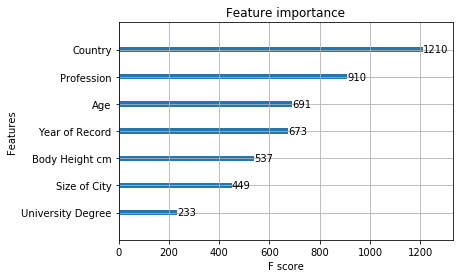

In [76]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
plot_importance(model)
plt.show()

In [148]:
Submit = pd.DataFrame()
Submit['Instance'] = test_set.index
Submit['Income'] = prediction
Submit.to_csv('AYUSH5.csv',index=False)